In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from uncertainties import  ufloat
from scipy import constants
from pathlib import Path
from typing import Tuple, List
from functools import partial
from time import time
import concurrent.futures
import tqdm
import os

In [93]:

Planet_data= pd.read_csv('Data/planets.csv', comment='#')

class PeakFinder:
    def __init__(self):
        self.feture_top = 4.26  # feature peak location
        self.feaure_bottom_2 = 4.47
        self.feture_bottom_1 = 4.115  # baseline location away from feature
        self.MAX_WORKERS = 8 # how many cores you have for paralisation

        self.top_bin_range_U = 4.27  # the upper bound of the topbin in microns 
        self.top_bin_range_L = 4.25 # the lower bound of the topbin in microns 
        self.Bottom_1_bin_range_U= 4.155
        self.Bottom_1_bin_range_L= 4.075
        self.Bottom_2_bin_range_U= 4.57 
        self.Bottom_2_bin_range_L= 4.37

        self.bin_size=5 # this is if you want to use the binning fucntion

    def Binning(self, data):
        """This function bins the data to reduce noise.
        Input is the data array
        Output is the binned data array"""
        Wavelengths= data[:,0] # in microns
        Spectrum= data[:,1] # data with the noise (Rp/Rs)^2
        error_bars= data[:,2] # error bars 
        Binned_Wavelengths = []
        Binned_Spectrum = []
        Binned_error_bars = []
        for i in range(0, len(Wavelengths), self.bin_size):
            Binned_Wavelengths.append(np.mean(Wavelengths[i:i+self.bin_size]))
            Binned_Spectrum.append(np.mean(Spectrum[i:i+self.bin_size]))
            Binned_error_bars.append(np.sqrt(np.sum(error_bars[i:i+self.bin_size]**2)) / self.bin_size)
        binned_data = np.column_stack((Binned_Wavelengths, Binned_Spectrum, Binned_error_bars))
        return binned_data
    
    def Plot_Peak_binning(self, data):
        mask = (abs(data[:,2])/1000000 ) < 0.1
        data= data[mask]
        Wavelengths= data[:,0] # in microns
        Spectrum= data[:,1]/1000000 # data with the noise (Rp/Rs)^2
        error_bars= abs(data[:,2])/1000000 # error bars 
        #--- Masks of the different points ---#
        Top_mask = (Wavelengths >= self.top_bin_range_L) & (Wavelengths<= self.top_bin_range_U) # all the points in range of the top 
        Bottom_1_mask = (Wavelengths >= self.Bottom_1_bin_range_L) & (Wavelengths<= self.Bottom_1_bin_range_U)  # one of the bottom points
        Bottom_2_mask = (Wavelengths >= self.Bottom_2_bin_range_L) & (Wavelengths <= self.Bottom_2_bin_range_U) # the other bottom point 
        #--- Peak points Spectrum ---#
        Top_point_S = np.mean(Spectrum[Top_mask]) 
        Bottom_1_point_S= np.mean(Spectrum[Bottom_1_mask])  
        Bottom_2_point_S = np.mean(Spectrum[Bottom_2_mask])

        #--- Peak points Wavelengths ---#
        Top_point_W = np.mean(Wavelengths[Top_mask]) 
        Bottom_1_point_W = np.mean(Wavelengths[Bottom_1_mask])  
        Bottom_2_point_W = np.mean(Wavelengths[Bottom_2_mask])
        #--- Uncertanty propergation ---# ]
        #sqrt(sum(σᵢ²))/N
        Top_error= np.sqrt(np.sum(error_bars[Top_mask]**2)) / len(error_bars[Top_mask]) # propergate the uncertanty
        Bottom_1_error = np.sqrt(np.sum(error_bars[Bottom_1_mask]**2)) / len(error_bars[Bottom_1_mask])
        Bottom_2_error = np.sqrt(np.sum(error_bars[Bottom_2_mask]**2)) / len(error_bars[Bottom_2_mask])

        # When combining N measurements with errors σᵢ, the error in the mean is sqrt(sum(σᵢ²))/N
        #--- Averages ---#
        Average_Bottom_S= (Bottom_1_point_S + Bottom_2_point_S)/2
        
        plt.figure(figsize=(10, 6))

        # --- Full spectrum (background) ---
        plt.errorbar(
            Wavelengths,
            Spectrum,
            yerr=error_bars,
            fmt='o',
            markersize=3,
            alpha=0.35,
            color='black',
            ecolor='lightgray',
            elinewidth=1,
            capsize=0,
            label='Observed spectrum',
            zorder=1
        )

        # --- Averaged baseline points ---
        plt.errorbar(
            [Bottom_1_point_W, Bottom_2_point_W],
            [Bottom_1_point_S, Bottom_2_point_S],
            yerr=[Bottom_1_error, Bottom_2_error],
            fmt='o',
            markersize=9,
            color='tab:blue',
            capsize=4,
            label='Baseline bins',
            zorder=3
        )

        # --- Peak point ---
        plt.errorbar(
            Top_point_W,
            Top_point_S,
            yerr=Top_error,
            fmt='o',
            markersize=11,
            color='tab:red',
            capsize=4,
            label='Feature bin',
            zorder=4
        )

        # --- Baseline average ---
        plt.hlines(
            Average_Bottom_S,
            xmin=Bottom_1_point_W,
            xmax=Bottom_2_point_W,
            colors='tab:blue',
            linestyles='--',
            linewidth=2,
            alpha=0.8,
            label='Average baseline',
            zorder=2
        )

        plt.ylim(0,0.005)

        # --- Labels & cosmetics ---
        plt.xlabel('Wavelength [$\\mu$m]')
        plt.ylabel('Transit depth $(R_p/R_s)^2$')

        plt.legend(frameon=False)
        plt.grid(alpha=0.25)

        plt.tight_layout()
        plt.show()

        
    
    def find_peaks(self, data):
        """This Function takes a spectrun array and looks for a feture depth between two ranges.
        Input is just the data array
        Output is the feture depth and its error bar"""
        #--- This gets rid of the points with super high uncertainty
        mask = (abs(data[:,2])/1000000 ) < 0.1
        data= data[mask]
        
        Wavelengths= data[:,0] # in microns
        Spectrum= data[:,1]/1000000# data with the noise (Rp/Rs)^2
        error_bars= data[:,2]/1000000 # error bars 


        #--- Masks of the different points ---#
        Top_mask = (Wavelengths >= self.top_bin_range_L) & (Wavelengths<= self.top_bin_range_U) # all the points in range of the top 
        Bottom_1_mask = (Wavelengths >= self.Bottom_1_bin_range_L) & (Wavelengths<= self.Bottom_1_bin_range_U)  # one of the bottom points
        Bottom_2_mask = (Wavelengths >= self.Bottom_2_bin_range_L) & (Wavelengths <= self.Bottom_2_bin_range_U) # the other bottom point 

        #--- Means ---#
        Top_point = np.mean(Spectrum[Top_mask]) 
        Bottom_1_point= np.mean(Spectrum[Bottom_1_mask])  
        Bottom_2_point = np.mean(Spectrum[Bottom_2_mask])

        #--- Uncertanty propergation ---# ]
        #sqrt(sum(σᵢ²))/N
        Top_error= np.sqrt(np.sum(error_bars[Top_mask]**2)) / len(error_bars[Top_mask]) # propergate the uncertanty
        Bottom_1_error = np.sqrt(np.sum(error_bars[Bottom_1_mask]**2)) / len(error_bars[Bottom_1_mask])
        Bottom_2_error = np.sqrt(np.sum(error_bars[Bottom_2_mask]**2)) / len(error_bars[Bottom_2_mask])

        # When combining N measurements with errors σᵢ, the error in the mean is sqrt(sum(σᵢ²))/N
        #--- Averages ---#
        Average_Bottom= (Bottom_1_point + Bottom_2_point)/2
        Average_Bottom_error= np.sqrt((Bottom_1_error**2) + (Bottom_2_error**2))/2

        #--- Feature height ---#
        Feature_depth= Top_point- Average_Bottom
        Feature_depth_error = np.sqrt(Top_error**2 + Average_Bottom_error**2)

        print(f"The feture depth is {Feature_depth} +/- {Feature_depth_error} (Rp/Rs)^2")
        return Feature_depth, Feature_depth_error
    

    def get_planet_name(self, file_path: Path):
        try:  # the try is there just in case a fuck up 
            file_name= os.path.basename(file_path)
            #--- Remove all the stuff that isn't the planet name ---#
            planet_name= file_name.removesuffix('_JWST_results.csv')
        except:
            #--- The code can deal with this ---#
            print('planet name not found')
            planet_name= 'Unknown'

        #--- Put some logic about how many transits in here ---#
        Number_of_transits = None
        return planet_name, Number_of_transits


    def Find_A_H(self, peak_height, Error, planet_name):
        #--- Get all the variables from the planet database ---#
        R_s = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'st_rad'].values[0]  * 695700000 # radius of the star
        R_p = Planet_data.loc[Planet_data ['pl_name'] == planet_name, 'pl_rade'].values[0] * 6378137 # planetary radius in earth radii
        R_p_error = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'pl_radeerr_avg'].values[0] * 6378137# planetary radius error in earth radii 
        R_s_error =Planet_data.loc[Planet_data['pl_name'] == planet_name, 'st_raderr_avg'].values[0]  * 695700000 # stellar radius error in earth radii
        g = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'g_planet_cgs'].values[0] *0.01 # surface gravity in m/s^2 need to get from somewhere
        g_error = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'g_planet_cgs_err'].values[0] *0.01# surface gravity error in m/s^2
        T_eq = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'pl_Teq'].values[0]  # equilibrium temperature in K need to get from somewhere
        T_eq_error = Planet_data.loc[Planet_data['pl_name'] == planet_name, 'pl_Teq_err'].values[0]  # equilibrium temperature error in K
        mu = 5.2 * constants.physical_constants['atomic mass unit-kilogram relationship'][0] # mean molecular weight (From the group 1) 
        k_B = constants.physical_constants['Boltzmann constant'][0]  # Boltzmann constant in J/K

        #--- Make all the variables ufloats so the uncertanries are calculated by the uncertanies package ---#
        R_p_full = ufloat(R_p, R_p_error)
        R_s_full = ufloat(R_s, R_s_error)
        g_full = ufloat(g, g_error)
        T_eq_full = ufloat(T_eq, T_eq_error)
        Peak_height_full = ufloat(peak_height, Error)
        

        #--- Calculate amplitude A_H with uncertanties ---#
        A_H_full = (Peak_height_full* R_s_full**2 * mu * g_full) / (k_B * T_eq_full * R_p_full)
        A_H_error = A_H_full.s
        A_H = A_H_full.n

        print(f"The amplitude A_H is {A_H_full:.2f}")
        return T_eq, T_eq_error, A_H, A_H_error

    def process_file(self, file_path: Path) -> Tuple[Tuple, float]:
        """ This is the function that applies all the quality checks and processes a single file.
        Input is the file path.
        Output is a tuple of results and the time taken to process the file."""
        start_time = time() # just to see how long it takes
        try:
            data = np.genfromtxt(file_path, delimiter=',') # open the file
            data= data[1:]
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            return (None, None, None), time() - start_time
        
        #--- Find the heigth of the feture ---#
        Feture_depth, Feature_error = self.find_peaks(data)

        #--- Get the planet name form the file name ---#
        planet_name, Number_of_transits =  self.get_planet_name(file_path) 

        if planet_name == 'Unknown': #if it can't get the planet name
            print(f"Planet name for {file_path} is unknown. Skipping A_H calculation.")
            print(f"The feture depth is {Feture_depth} +/- {Feature_error} (Rp/Rs)^2")
            return (file_path.name, Feture_depth, Feature_error), time() - start_time
        else:
            T_eq, T_eq_error, A_H, A_H_error = self.Find_A_H(Feture_depth, Feature_error, planet_name)  #convets into atmospheric heights

        duration = time() - start_time
        return (file_path.name, T_eq, T_eq_error, A_H, A_H_error, Number_of_transits), duration  #outputs that data and the time 
    

    def _print_processing_stats(self, num_files: int, total_duration: float, times: List[float]) -> None:
        """Print processing statistics"""
        avg_time = sum(times) / len(times) if times else 0
        print(f"Processed {num_files} files")
        print(f"Total time: {total_duration:.2f} seconds")
        print(f"Average time per file: {avg_time:.3f} seconds")
        print(f"Files per second: {num_files / total_duration:.2f}")


    

    def process_folder(self, folder: Path)-> Tuple[np.ndarray, ...]:
        """This function will take a folder filled with spectra files and process each one to find the peak depths.
        Input is the folder path
        Output is a list of peak depths and their error bars for each file"""
        
        Spectra_files = []

        #--- Search for .txt files recursively ---#
        for pattern in ['*.csv']:  # Case insensitive search
            Spectra_files.extend(list(folder.rglob(pattern)))
        
        #--- Remove duplicates while preserving order ---#
        #This may have to be changed depending on how we manage multiple transists of one planet
        seen = set()
        unique_files = []
        for f in Spectra_files:
            if f not in seen:
                seen.add(f)
                unique_files.append(f)
        
        Spectra_files = unique_files
        print(f"Found {len(Spectra_files)} .txt files")
        
        if not Spectra_files:
            print("No .txt files found!")
            return tuple()

        #--- Lists for all the results and stuff so they don't need to be a certain lenght ---#
        results = []
        times = []
        failed_files = []
        

        process_fn = partial(self.process_file) # for the paralisation
        total_start = time()
        
        #--- limit the batch size to save memory ---#
        batch_size = min(1000, len(Spectra_files))
        
        for batch_start in range(0, len(Spectra_files), batch_size): #go throught each batch 
            batch_end = min(batch_start + batch_size, len(Spectra_files))
            batch_files = Spectra_files[batch_start:batch_end]
            
            print(f"Processing batch {batch_start//batch_size + 1}/{(len(Spectra_files)-1)//batch_size + 1}")
            
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.MAX_WORKERS) as executor: #proces multiple files at the same time 
                futures = {executor.submit(process_fn, file_path): i for i, file_path in enumerate(batch_files)}
                
                #--- Create a list to store results in original order ---#
                batch_results = [None] * len(batch_files)
                
                for future in tqdm.tqdm(concurrent.futures.as_completed(futures),
                                   total=len(batch_files), desc=f"Processing batch"):
                    result, duration = future.result() # get the outputs
                    original_index = futures[future] # keep the order the same 
                    
                    if result[0] is None:
                        failed_files.append(batch_files[original_index])
                    else:
                        batch_results[original_index] = (result, duration)
                
                #--- Add results to the main list in order ---#
                for item in batch_results:
                    if item is not None:
                        result, duration = item
                        results.append(result)
                        times.append(duration)
        
        
        total_duration = time() - total_start
        
        print(f"Successfully processed: {len(results)} files")
        print(f"Failed to process: {len(failed_files)} files")
        
        
        if not results:
            print("No valid data processed.")
            if failed_files:
                print("Sample failed files:")
                for f in failed_files[:5]:
                    print(f"  {f}")
            return tuple()
        
        #--- Print statistics ---#
        self._print_processing_stats(len(results), total_duration, times)
        
        
        #--- Check the structure of results to handle both 3-tuple and 5-tuple returns ---#
        if results:
            #--- All results should have the same structure (all 3-tuples when planet_name is 'Unknown') ---#
            num_elements = len(results[0])
            if num_elements == 3: #This is if the planet name is unknown
                file_names, Feture_depth, Feture_depth_error = zip(*results)
                #--- Convert to numpy arrays ---#
                file_names = np.array(file_names, dtype='object')
                Feture_depth_error = np.array(Feture_depth_error, dtype=np.float64)
                Feture_depth = np.array(Feture_depth, dtype=np.float64)
                
                #--- Turn into one big array ---#
                Results_array = np.stack((file_names, Feture_depth, Feture_depth_error), axis=-1)

                #--- save the results as a .txt in the same folder for ease of finding ---#
                np.savetxt(folder / "results.txt", Results_array, fmt='%s', header='File_Name Feture_depth Feture_depth_error')

            elif num_elements == 6:  # this is what should happen 
                file_names, T_eq, T_eq_error, A_H, A_H_error, Number_of_transits = zip(*results)

                #--- convert to array ---#
                file_names = np.array(file_names, dtype='object')
                T_eq= np.array(T_eq, dtype= np.float64)
                T_eq_error= np.array(T_eq_error, dtype= np.float64)
                A_H= np.array(A_H, dtype= np.float64)
                A_H_error= np.array(A_H_error, dtype = np.float64)

                #--- stack all the arrays ---#
                Results_array= np.stack((file_names,T_eq,T_eq_error,A_H, A_H_error, Number_of_transits), axis=-1)

                #--- save all the results
                np.savetxt(folder/"results.csv", Results_array, fmt='%s', header='File_Name, Equilibrium_Temperature, Uncertainty_on_Equilibrium_Temperature, A_H, A_H_error, Number_of_transits', delimiter=',')
            else:
                raise ValueError(f"Unexpected result structure with {num_elements} elements")
            

        else:
            Results_array = np.array([])
 
        return Results_array


In [83]:
def folder_run():
    peak_finder = PeakFinder()
    folder_path = Path(r'C:\Users\Miles\OneDrive\Documents\uni stuff\Year 3\Group studies\Group-Studies---Exoplanets\Group 1 Full Loop Code\pandexo csv files')
    results = peak_finder.process_folder(folder_path)
    return results

results = folder_run()
      


Found 18 .txt files
Processing batch 1/1


Processing batch:   6%|▌         | 1/18 [00:00<00:07,  2.43it/s]

The feture depth is 0.00010527318413778176 +/- 0.0006659341619812534 (Rp/Rs)^2
The feture depth is 6.578597181489294e-05 +/- 0.0005577515092400666 (Rp/Rs)^2
The feture depth is 0.0001732305418192504 +/- 0.0006196147533428896 (Rp/Rs)^2
The amplitude A_H is 12.57+/-79.55
The feture depth is 0.00011776874296394891 +/- 0.0010375180916050025 (Rp/Rs)^2
The amplitude A_H is 13.41+/-118.17
The amplitude A_H is 13.42+/-113.87
The amplitude A_H is 10.65+/-38.14
The feture depth is 8.842648334595198e-05 +/- 0.0001976408398624485 (Rp/Rs)^2
The amplitude A_H is 7.66+/-17.21
The feture depth is 0.00012340839441940706 +/- 0.0003874628571417546 (Rp/Rs)^2
The amplitude A_H is 13.33+/-42.01
The feture depth is 0.0002416593756020798 +/- 0.0004966176501497195 (Rp/Rs)^2
The amplitude A_H is 11.21+/-23.07
The feture depth is 0.00015831279458331784 +/- 0.0006798337051608282 (Rp/Rs)^2
The amplitude A_H is 9.78+/-42.03


Processing batch: 100%|██████████| 18/18 [00:00<00:00, 26.93it/s]

The feture depth is 0.00011351331099908064 +/- 0.0006295264925167202 (Rp/Rs)^2
The amplitude A_H is 13.83+/-76.81
The feture depth is 0.00010671686029278425 +/- 0.0003578712524591097 (Rp/Rs)^2
The amplitude A_H is 8.71+/-29.22
The feture depth is 0.00015049704726887315 +/- 0.0005500485146821269 (Rp/Rs)^2
The amplitude A_H is 13.35+/-48.93
The feture depth is 2.754151461591874e-05 +/- 0.00013418325869270743 (Rp/Rs)^2
The amplitude A_H is 8.88+/-43.41
The feture depth is 5.672725020288132e-05 +/- 0.000244480847370561 (Rp/Rs)^2
The amplitude A_H is 8.10+/-34.94
The feture depth is 6.283309981241049e-05 +/- 0.00023348530862983747 (Rp/Rs)^2
The amplitude A_H is 9.70+/-36.13
The feture depth is 0.0001169706081977813 +/- 0.0006429803530989799 (Rp/Rs)^2
The amplitude A_H is 8.61+/-47.34
The feture depth is 0.00011915996917498612 +/- 0.0004990574774256947 (Rp/Rs)^2
The amplitude A_H is 11.86+/-49.68
The feture depth is 0.0002857539137756538 +/- 0.0017400137838753625 (Rp/Rs)^2
The amplitude A_H 

0.002724024648112144


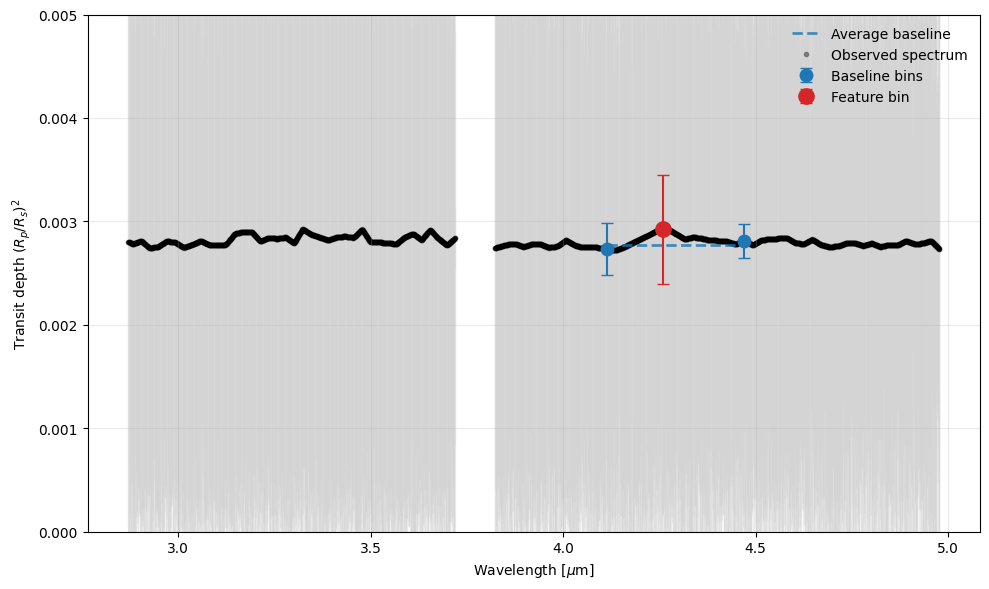

In [94]:
def One_File():
    """This is the main function that will execute when the script is run.
    Can change to be whatever you want to run."""
    data = np.genfromtxt(r'C:\Users\Miles\OneDrive\Documents\uni stuff\Year 3\Group studies\Group-Studies---Exoplanets\Group 1 Full Loop Code\pandexo csv files\TOI-1468 c_JWST_results.csv', delimiter=',') # open the file
    data= data[1:]
    print(np.min(data[:,1])/1000000)    
    PeakFinder().Plot_Peak_binning(data=data)

    

if __name__ == "__main__":
    One_File()


In [ ]:
amplitudes = []
for i in range(10):
    # Wavelengths (microns)
    wavelength = np.linspace(2.5, 7.5, 1000)

    # Baseline transit depth
    baseline = 0.010

    # Absorption feature at 5 microns
    feature_center = 5.0
    feature_width = 0.25
    feature_amplitude = np.random.uniform(2e-4, 1e-3)
    amplitudes.append(feature_amplitude)

    feature = feature_amplitude * np.exp(
        -0.5 * ((wavelength - feature_center) / feature_width)**2
    )

    # Measurement noise
    noise = np.random.normal(0, 4e-5, size=wavelength.size)

    # Transit depth
    transit_depth = baseline + feature + noise

    # JWST-like uncertainties (slightly wavelength-dependent)
    yerr = 3e-5 + 2e-5 * (wavelength - wavelength.min()) / (wavelength.max() - wavelength.min())
    dumby= np.zeros_like(wavelength)

    # Final array: [x, y, y_err]
    spectrum = np.column_stack((wavelength, dumby, transit_depth, yerr))
    np.savetxt(f'Data/Fake_Data_for_folder_testing/sim_obs{i}.txt', spectrum)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Fake_Data_for_folder_testing/sim_obs0.txt'

In [ ]:
print(amplitudes)

[0.0009257602195585026, 0.0002099019914193991, 0.0003024960092218319, 0.0003936950857258146, 0.0003687044484210883, 0.0003288066585064593, 0.0006153959804672307, 0.0008604344096790501, 0.00029251768890765, 0.0007776413094012449]


In [22]:
array_1= np.genfromtxt(r'C:\Users\Miles\OneDrive\Documents\uni stuff\Year 3\Group studies\Group-Studies---Exoplanets\Group 1 Full Loop Code\pandexo csv files\GJ 1214 b_JWST_results.csv', delimiter=',')
print(array_1[1:])

[[ 2.87054407e+00  1.38392649e+04  1.37595995e+04]
 [ 2.87121992e+00  1.38442893e+04  1.37910031e+04]
 [ 2.87189576e+00  1.38493137e+04  1.31750310e+04]
 ...
 [ 5.17539430e+00  1.35120000e+04  3.09379549e+09]
 [ 5.17603604e+00  1.35120000e+04  3.31299531e+08]
 [ 5.17667779e+00  1.35120000e+04 -4.63514766e+09]]
